In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle                      
import cv2                                 
import tensorflow as tf                

2024-05-15 11:23:22.437372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 11:23:22.437488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 11:23:22.583524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (50, 50)

def load_data():
    datasets = ['/kaggle/input/face-expression-recognition-dataset/images/train/']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            count = 0
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
#                 image = cv2.imread(img_path)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
                # Taking only 100 images from of each type because of 
                # MemoryError: Unable to allocate 3.53 GiB for an array with shape (14034, 150, 150, 3) and data type float32
                count = count + 1
                if count == 2000:
                    break
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [3]:
(images, labels) = load_data()[0]

Loading /kaggle/input/face-expression-recognition-dataset/images/train/


 28%|██▊       | 1999/7164 [00:11<00:29, 177.82it/s]


In [4]:
permutation  = np.random.permutation(len(images))

shuffled_images = images[permutation]
shuffled_labels = labels[permutation]

In [5]:
# Memory taken by array
(images.nbytes/1024)/1024

118.59893798828125

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.1, shuffle=True)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((11192, 50, 50), (11192,), (1244, 50, 50), (1244,))

In [7]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [22]:
def display_random_image(class_names, images, labels):   
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

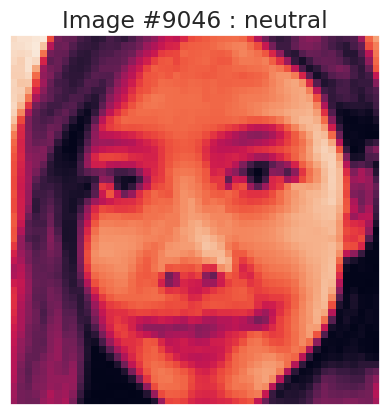

In [9]:
display_random_image(class_names, train_images, train_labels)

In [115]:
# import keras_tuner
# from tensorflow.keras import layers 

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     no_of_filters_layer1 = hp.Int("no_of_filters_layer1", min_value=16, max_value=128, step=16)
    
#     model.add(Conv2D(name="conv2d_layer1", filters=no_of_filters_layer1, kernel_size=(3, 3), padding='same', input_shape=(50, 50, 1)))
    
#     if hp.Boolean("BatchNormalization_1"):
#         model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     dropuout_rate_1 = hp.Float("dropuout_rate_1", min_value=0, max_value=0.4, step=0.2)
#     model.add(layers.Dropout(rate=dropuout_rate_1))
              
              

#     hp_cnn_layers = hp.Int('cnn_layers', min_value=1, max_value=4, step=1)
#     for i in range(hp_cnn_layers):
#         no_of_filters = hp.Int(name=f'no_of_filters_{i}', min_value=32, max_value=256, step=16)
        
#         model.add(Conv2D(name=f'conv2d_layer_{i}', filters=no_of_filters, kernel_size=(3, 3), padding='same'))
#         if hp.Boolean("BatchNormalization_1"):
#             model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         dropuout_rate_1 = hp.Float(name=f'dropout_rate_{i}', min_value=0, max_value=0.4, step=0.2)
#         model.add(layers.Dropout(rate=dropuout_rate_1))
    
        
#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(32, activation='relu'))
#     model.add(tf.keras.layers.Dense(7, activation='softmax'))    
        
#     # Define the optimizer learning rate as a hyperparameter.
#     learning_rate = hp.Float("lr", min_value=0.0001, max_value=0.01, sampling="log")
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss="sparse_categorical_crossentropy",
#         metrics=["accuracy"],
#     )
#     print(model.summary())
#     tf.keras.utils.plot_model(model)
#     return model

In [15]:
# build_model(keras_tuner.HyperParameters())

In [16]:
# tuner = keras_tuner.RandomSearch(
#     hypermodel=build_model,
#     objective="val_accuracy",
#     max_trials=30,
#     overwrite=True,
#     directory="my_dir",
#     project_name="helloworld",
# )

In [17]:
# tuner.search(train_images, train_labels, epochs=20, validation_split=0.2, callbacks=[tf.keras.callbacks.TensorBoard("/tmp/tb_logs")])

In [18]:
# tuner.results_summary()

In [28]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (50, 50, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 22, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 22, 22, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,527 (451.28 KB)

 Trainable params: 115,047 (449.40 KB)

 Non-trainable params: 480 (1.88 KB)

In [29]:
history = model2.fit(train_images, train_labels, batch_size=128, epochs=40, validation_split = 0.1)

Epoch 1/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.1901 - loss: 2.2672 - val_accuracy: 0.1723 - val_loss: 2.0085
Epoch 2/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.2379 - loss: 1.8573 - val_accuracy: 0.1625 - val_loss: 2.1927
Epoch 3/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.2844 - loss: 1.7866 - val_accuracy: 0.1598 - val_loss: 2.4368
Epoch 4/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.3080 - loss: 1.7343 - val_accuracy: 0.2045 - val_loss: 2.4002
Epoch 5/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.3309 - loss: 1.6902 - val_accuracy: 0.2018 - val_loss: 2.1701
Epoch 6/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.3600 - loss: 1.6416 - val_accuracy: 0.2500 - val_loss: 2.0083
Epoch 7/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - accuracy: 0.3771 - loss: 1.6028 - val_accuracy: 0.3670 - val_loss: 1.6703
Epoch 8/40
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.3881 - loss: 1.5639 - val_accu

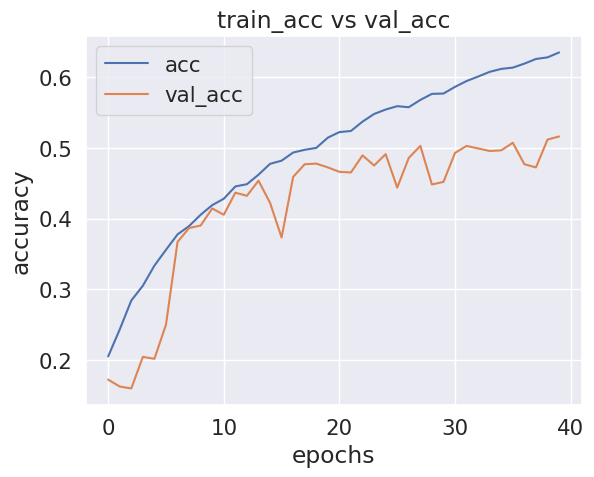

In [30]:
plt.plot(history.history['accuracy'], label = "acc")
plt.plot(history.history['val_accuracy'], label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


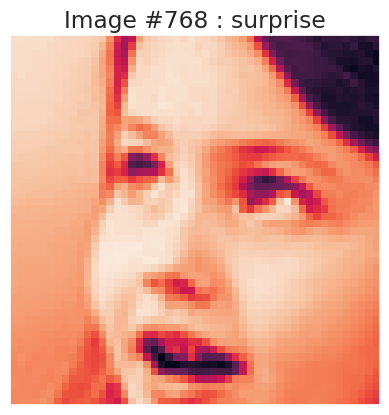

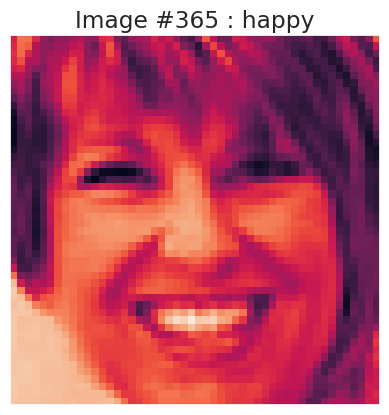

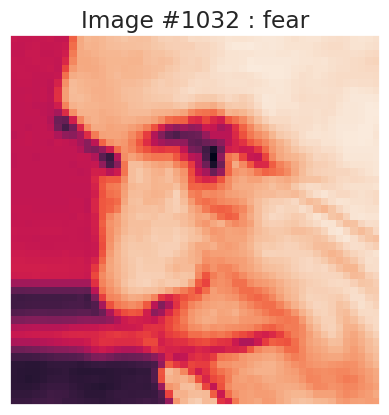

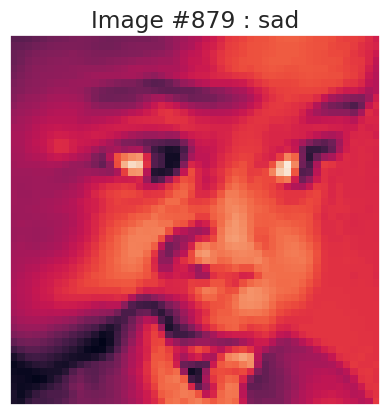

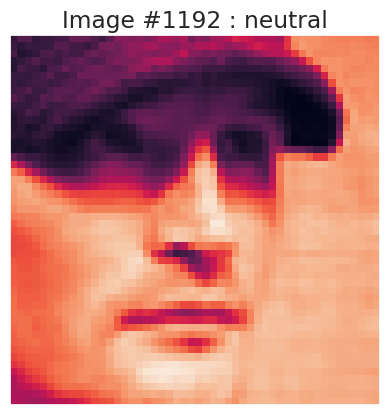

In [32]:
predictions = model2.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

for i in range(5):
    display_random_image(class_names, test_images, pred_labels) 

<div style="color:white;
            display:fill;
            border-radius:15px;
            background-color:skyblue;
            font-size:100%;
            font-family:Verdana;
            letter-spacing:1px">
    <h2 style='padding: 20px;
              color:black;
              text-align:center;'>
        IF YOU LIKED THE NOTEBOOK PLEASE DO UPVOTE!  
    </h2>
    </div>